In [1]:
import sys
import os
import time
import numpy as np
import tensorflow as tf
import gpflow
import soundfile
import pickle
sys.path.append('../../../../')
import gpitch
from gpitch.amtgp import logistic
from gpitch import myplots

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
active_device = sys.argv[1]  # configure gpu usage and plotting
gpitch.amtgp.init_settings(visible_device = active_device, interactive=True)

In [4]:
dirloc = '../../../../../datasets/maps/sample_rate_16khz/'
pattern = '*F*.wav'
bounds = [21, 109]
filel = gpitch.amtgp.load_filenames(directory=dirloc, pattern=pattern, bounds=bounds)
Np = filel.size  # number of pitches to analyze

In [5]:
fs = 16e3
N = 16000  # number of data points to load
x = np.linspace(0, (N-1.)/fs, N).reshape(-1, 1)

16_khz_MAPS_ISOL_NO_F_S1_M21_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S1_M22_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M23_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S1_M24_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S1_M25_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S1_M26_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S1_M27_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M28_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M29_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M30_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M31_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M32_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M33_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S1_M34_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S1_M35_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M36_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M37_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M38_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S1_M39_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S1_M40_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S1_M41_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M42_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M43_AkPnBcht.wav
16_khz_MAPS_ISOL_NO_F_S0_M44_AkPnB

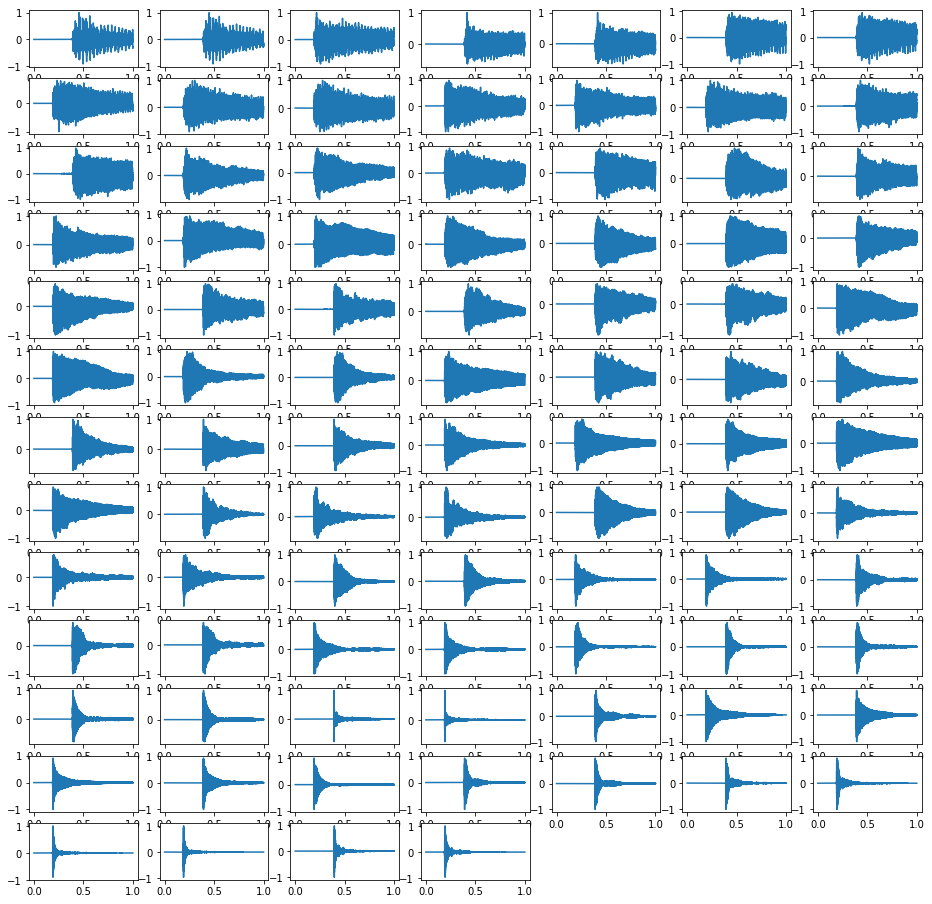

In [14]:
plt.figure(figsize=(16, 16))
for i in range(Np):
    print(filel[i])
    y, fs = gpitch.amtgp.wavread(dirloc + filel[i], start=5000, N=N)  # load data
    plt.subplot(13, 7, i+1)
    plt.plot(x, y)
    #plt.legend([filel[i]])

In [7]:
tf.reset_default_graph()